## Imports 

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE, SequentialFeatureSelector, VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tabulate import tabulate
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

## Import tech company salary dataset

In [2]:
"""
Reads a CSV file into a pandas DataFrame and cleans the 'totalyearlycompensation' column.
The 'totalyearlycompensation' column is divided by 10 if its value exceeds the maximum salary.
Finally, the first few rows of the DataFrame are displayed.
"""

import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('tech_companies_salary.csv')

# Define the valid salary range
min_salary = 30000
max_salary = 450000

# Clean the 'totalyearlycompensation' column
df['totalyearlycompensation'] = df['totalyearlycompensation'].apply(
    lambda x: x / 10 if x > max_salary else x
)

# Display the first few rows of the DataFrame
df.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,06-07-2017 11:33,Oracle,L3,Product Manager,127000.0,"Redwood City, CA",1.5,1.5,NaN,107000,...,0,0,0,0,0,0,0,0,NaN,NaN
1,06-10-2017 17:11,eBay,SE 2,Software Engineer,100000.0,"San Francisco, CA",5.0,3.0,NaN,0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,06-11-2017 14:53,Amazon,L7,Product Manager,310000.0,"Seattle, WA",8.0,0.0,NaN,155000,...,0,0,0,0,0,0,0,0,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000.0,"Sunnyvale, CA",7.0,5.0,NaN,157000,...,0,0,0,0,0,0,0,0,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000.0,"Mountain View, CA",5.0,3.0,NaN,0,...,0,0,0,0,0,0,0,0,NaN,NaN


## Fill in missing data

In [3]:
# Create a duplicate of the original DataFrame to preserve the original data
new_df = df.copy()

# Impute missing values in specified columns with the mean of each column
columns_to_fill = ['totalyearlycompensation', 'yearsofexperience', 'yearsatcompany', 'bonus']
new_df[columns_to_fill] = new_df[columns_to_fill].fillna(new_df[columns_to_fill].mean())

# Verify the presence of missing values in the DataFrame
missing_values_check = new_df.isnull().any()


## Remove missing data

In [4]:
# Remove rows with missing values in critical columns to ensure data integrity
columns_to_drop_na = ['Education', 'title', 'location', 'company', 'level', 'tag']
new_df = new_df.dropna(subset=columns_to_drop_na)

# Verify the absence of missing values in relevant columns
# Note: Sensitive attributes 'Gender' and 'Race' are excluded from analysis due to ethical considerations.
print("Missing value check:")
print(new_df.isnull().any())

Missing value check:
timestamp                  False
company                    False
level                      False
title                      False
totalyearlycompensation    False
location                   False
yearsofexperience          False
yearsatcompany             False
tag                        False
basesalary                 False
stockgrantvalue            False
bonus                      False
gender                      True
otherdetails               False
cityid                     False
dmaid                      False
rowNumber                  False
Masters_Degree             False
Bachelors_Degree           False
Doctorate_Degree           False
Highschool                 False
Some_College               False
Race_Asian                 False
Race_White                 False
Race_Two_Or_More           False
Race_Black                 False
Race_Hispanic              False
Race                        True
Education                  False
dtype: bool


## Remove Duplicates

In [5]:
# Remove duplicate rows to prevent data redundancy and ensure unique observations
new_df = new_df.drop_duplicates()

## Remove Outliers

In [6]:
# Define a function to detect and remove outliers from a DataFrame column using the Interquartile Range (IQR) method
def remove_outliers_iqr(df, column, threshold=1.5):
    """
    Removes outliers from a DataFrame column using the IQR method.

    Parameters:
    df (DataFrame): Input DataFrame
    column (str): Column name to clean
    threshold (float, optional): IQR threshold (default=1.5)

    Returns:
    DataFrame: Cleaned DataFrame with outliers removed
    """
    q1, q3 = df[column].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - threshold * iqr, q3 + threshold * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Specify columns to clean using the IQR method
columns_to_clean = ['totalyearlycompensation', 'yearsofexperience', 'bonus', 'basesalary', 'stockgrantvalue']

# Apply outlier removal to each column and track progress
for column in columns_to_clean:
    new_df = remove_outliers_iqr(new_df, column)
    print(f"Removed outliers from {column}. New shape: {new_df.shape}")

# Print final DataFrame summary statistics
print("\nFinal DataFrame Summary:")
print("Shape:", new_df.shape)
print("Summary Statistics:")
print(new_df.describe())

Removed outliers from totalyearlycompensation. New shape: (29963, 29)
Removed outliers from yearsofexperience. New shape: (29217, 29)
Removed outliers from bonus. New shape: (27951, 29)
Removed outliers from basesalary. New shape: (27660, 29)
Removed outliers from stockgrantvalue. New shape: (25839, 29)

Final DataFrame Summary:
Shape: (25839, 29)
Summary Statistics:
       totalyearlycompensation  yearsofexperience  yearsatcompany  \
count             25839.000000       25839.000000    25839.000000   
mean             171315.743643           6.209896        2.442213   
std               75615.131332           4.837949        2.841558   
min               12000.000000           0.000000        0.000000   
25%              117000.000000           3.000000        0.000000   
50%              168000.000000           5.000000        2.000000   
75%              220000.000000           9.000000        3.000000   
max              425000.000000          20.000000       20.000000   

        

## Columns Available

In [7]:
print(new_df.columns)

Index(['timestamp', 'company', 'level', 'title', 'totalyearlycompensation',
       'location', 'yearsofexperience', 'yearsatcompany', 'tag', 'basesalary',
       'stockgrantvalue', 'bonus', 'gender', 'otherdetails', 'cityid', 'dmaid',
       'rowNumber', 'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree',
       'Highschool', 'Some_College', 'Race_Asian', 'Race_White',
       'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic', 'Race', 'Education'],
      dtype='object')


## DataFrame Column Selection: Keeping Relevant Features for Analysis
### This section has been changed based on data analysis from feature selection

In [8]:
# Specify the relevant columns to retain in the DataFrame
columns_to_keep = [
    'totalyearlycompensation',  # Total yearly compensation
    'title',  # Job title
    'level',  # Job level
    'stockgrantvalue',  # Stock grant value
    'tag',  # Job tag or category
    'yearsofexperience',  # Years of experience
    'Education',  # Education level
    'location',  # Job location
    'basesalary',  # Base salary
    'bonus'  # Bonus amount
]

# Create a new DataFrame with the selected columns
filtered_columns_df = new_df[columns_to_keep]

# Preview the resulting DataFrame
print("First few rows of the filtered DataFrame:")
filtered_columns_df.head()

First few rows of the filtered DataFrame:


,totalyearlycompensation,title,level,stockgrantvalue,tag,yearsofexperience,Education,location,basesalary,bonus
717,239000.0,Software Engineer,E4,60000.0,ML / AI,4.0,PhD,"Menlo Park, CA",140000,39000.0
3427,125000.0,Data Scientist,Senior Associate,0.0,ML / AI,1.0,PhD,"Washington, DC",121000,4000.0
5037,170000.0,Software Engineer,Software Engineer,0.0,Distributed Systems (Back-End),0.0,Master's Degree,"New York, NY",142000,18000.0
6055,240000.0,Software Engineer,ICT3,75000.0,ML / AI,3.0,PhD,"Cupertino, CA",150000,15000.0
7291,105000.0,Software Engineer,23,0.0,ML / AI,2.0,Master's Degree,"Houston, TX",105000,5000.0


## Defining and Filtering Job-Related Data: Titles, Locations, Levels, and Tags


In [9]:
# Define valid values for categorical columns to ensure data consistency
valid_titles = [
    'Data Scientist', 
    'Software Engineer', 
    'Software Engineering Manager', 
    'Hardware Engineer', 
    'Technical Program Manager', 
    'Product Designer', 
    'Management Consultant', 
    'Business Analyst', 
    'Solution Architect'
]

valid_locations = [
    'Seattle, WA', 
    'San Francisco, CA', 
    'New York, NY', 
    'Redmond, WA', 
    'Mountain View, CA'
]

valid_levels = [
    'L1', 
    'L2', 
    'L3', 
    'L4', 
    'L5', 
    'L6'
]

valid_tags = [
    'Full Stack', 
    'Distributed Systems (Back-End)', 
    'API Development (Back-End)', 
    'Web Development (Front-End)', 
    'Machine_Learning', 
    'Data'
]

# Filter the DataFrame to only include rows with valid categorical values
filtered_columns_df = filtered_columns_df[
    (filtered_columns_df['location'].isin(valid_locations)) & 
    (filtered_columns_df['level'].isin(valid_levels)) &
    (filtered_columns_df['tag'].isin(valid_tags)) &
    (filtered_columns_df['title'].isin(valid_titles))
]

# Standardize the 'tag' column by replacing 'ML / AI' with 'Machine_Learning'
filtered_columns_df.loc[:, 'tag'] = filtered_columns_df['tag'].replace('ML / AI', 'Machine_Learning')

# Preview the resulting filtered DataFrame
print("First few rows of the filtered DataFrame:")
filtered_columns_df.head()

First few rows of the filtered DataFrame:


,totalyearlycompensation,title,level,stockgrantvalue,tag,yearsofexperience,Education,location,basesalary,bonus
12506,172000.0,Software Engineer,L4,12000.0,Distributed Systems (Back-End),5.0,Master's Degree,"Seattle, WA",135000,25000.0
12512,144000.0,Software Engineer,L4,12000.0,Full Stack,0.0,Master's Degree,"Seattle, WA",112000,20000.0
12551,161000.0,Software Engineer,L5,19000.0,Full Stack,6.0,Master's Degree,"Seattle, WA",142000,0.0
12672,257000.0,Software Engineer,L4,69000.0,Distributed Systems (Back-End),3.0,Master's Degree,"Mountain View, CA",153000,35000.0
12732,195000.0,Software Engineer,L3,35000.0,Distributed Systems (Back-End),0.0,Master's Degree,"San Francisco, CA",135000,25000.0


## Grouping Job Levels into 'Junior' and 'Senior' Categories


In [10]:
# Create a new column 'level_combined' to categorize job levels into broader categories
level_mapping = {
    'Junior': ['L2', 'L3', 'L4'],
    'Senior': ['L5', 'L6']
}

filtered_columns_df['level_combined'] = filtered_columns_df['level'].apply(lambda x: next((k for k, v in level_mapping.items() if x in v), None))


## One-Hot Encoding and Data Cleaning: Encoding Categorical Variables and Dropping Redundant Columns


In [11]:
# Perform one-hot encoding on categorical columns to transform them into numerical features
encoded_df = pd.get_dummies(filtered_columns_df[['title', 'level_combined', 'tag', 'Education', 'location']], 
                            drop_first=True, dtype=int)

# Combine the original DataFrame with the one-hot encoded columns
valid_columns_df = pd.concat([filtered_columns_df, encoded_df], axis=1)

# Remove redundant columns, including original categorical columns and duplicate features
columns_to_drop = [
    'level', 'tag', 'title', 'Education', 'location', 'level_combined', 
    'title_Data Scientist', 'basesalary', 'Education_Some College', 'Education_Highschool', 
    'tag_Data', 'tag_Distributed Systems (Back-End)', 'tag_Full Stack', 'title_Solution Architect', 
    'location_Seattle, WA'
]
cleaned_df = valid_columns_df.drop(columns_to_drop, axis=1)

# Eliminate any duplicate columns to prevent feature redundancy
cleaned_df = cleaned_df.loc[:, ~cleaned_df.columns.duplicated()]

# Preview the resulting cleaned DataFrame
print("First few rows of the cleaned DataFrame:")
cleaned_df.head()

First few rows of the cleaned DataFrame:


,totalyearlycompensation,stockgrantvalue,yearsofexperience,bonus,title_Product Designer,title_Software Engineer,title_Software Engineering Manager,title_Technical Program Manager,level_combined_Senior,tag_Web Development (Front-End),Education_Master's Degree,Education_PhD,"location_New York, NY","location_Redmond, WA","location_San Francisco, CA"
12506,172000.0,12000.0,5.0,25000.0,0,1,0,0,0,0,1,0,0,0,0
12512,144000.0,12000.0,0.0,20000.0,0,1,0,0,0,0,1,0,0,0,0
12551,161000.0,19000.0,6.0,0.0,0,1,0,0,1,0,1,0,0,0,0
12672,257000.0,69000.0,3.0,35000.0,0,1,0,0,0,0,1,0,0,0,0
12732,195000.0,35000.0,0.0,25000.0,0,1,0,0,0,0,1,0,0,0,1


## Split Dataset into Training Dataset and Test Dataset

In [12]:
# Split the cleaned DataFrame into training and testing sets to evaluate model performance
from sklearn.model_selection import train_test_split

# Define the feature set (X) and the target variable (y)
X = cleaned_df.drop("totalyearlycompensation", axis=1)  # Features
y = cleaned_df["totalyearlycompensation"]  # Target variable

# Split the data into training and testing sets with a 80-20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Method 1: Variance Threshold (remove features with low variance)

In [13]:
# Create a dictionary to store the selected features from different feature selection methods
selected_features = {}

# Use VarianceThreshold to select features with a variance threshold of 0.1
from sklearn.feature_selection import VarianceThreshold

selector_variance = VarianceThreshold(threshold=0.1)
selector_variance.fit(X_train)

# Get the selected features and store them in the dictionary
selected_features['Variance Threshold'] = X_train.columns[selector_variance.get_support()].tolist()

### Method 2: Correlation (check and remove highly correlated features)


In [14]:
# Calculate the correlation matrix of the training data
correlation_matrix = X_train.corr().abs()

# Get the upper triangle of the correlation matrix
# This is done to avoid duplicate comparisons and to only consider the correlations between different features
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Identify the features with high correlation (above 0.9)
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Select the features that are not highly correlated with each other
selected_features['Correlation'] = X_train.columns.difference(high_corr_features).tolist()

### Method 3: Statistical Test (SelectKBest with ANOVA F-test)s


In [15]:
# Use SelectKBest to select the top 11 features based on the F-regression score
# The F-regression score is a statistical test that measures the correlation between each feature and the target variable
selector_kbest = SelectKBest(score_func=f_regression, k=14)

# Fit the SelectKBest selector to the training data
selector_kbest.fit(X_train, y_train)

# Get the selected features and store them in the dictionary
selected_features['Statistical Test (SelectKBest)'] = X_train.columns[selector_kbest.get_support()].tolist()

### Method 4: Forward Selection with Linear Regression


In [16]:
# Use SequentialFeatureSelector to perform forward selection with linear regression
# This selects the top 10 features that have the highest correlation with the target variable
lr_model = LinearRegression()  # Create a linear regression model
forward_selector = SequentialFeatureSelector(lr_model, n_features_to_select=13, direction='forward', scoring='neg_mean_squared_error', cv=14)

# Fit the forward selector to the training data
forward_selector.fit(X_train, y_train)

# Get the selected features and store them in the dictionary
selected_features['Forward Selection (Linear Regression)'] = X_train.columns[forward_selector.get_support()].tolist()

### Method 5: Recursive Feature Elimination (RFE) with Decision Tree Regressor


In [17]:
# Use Recursive Feature Elimination (RFE) with a decision tree regressor to select the top 11 features
dt_model = DecisionTreeRegressor()  # Create a decision tree regressor model
rfe_selector = RFE(dt_model, n_features_to_select=14)  # Initialize the RFE selector with the decision tree model and the number of features to select

# Fit the RFE selector to the training data
rfe_selector.fit(X_train, y_train)

# Get the selected features and store them in the dictionary
selected_features['RFE (Decision Tree Regressor)'] = X_train.columns[rfe_selector.get_support()].tolist()

### Display the Features Selected by Each Method

In [18]:
selected_features_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in selected_features.items()]))
selected_features_df

,Variance Threshold,Correlation,Statistical Test (SelectKBest),Forward Selection (Linear Regression),RFE (Decision Tree Regressor)
0,stockgrantvalue,stockgrantvalue,stockgrantvalue,stockgrantvalue,stockgrantvalue
1,yearsofexperience,yearsofexperience,yearsofexperience,yearsofexperience,yearsofexperience
2,bonus,bonus,bonus,bonus,bonus
3,level_combined_Senior,title_Product Designer,title_Product Designer,title_Software Engineer,title_Product Designer
4,Education_Master's Degree,title_Software Engineer,title_Software Engineer,title_Software Engineering Manager,title_Software Engineer
5,"location_New York, NY",title_Software Engineering Manager,title_Software Engineering Manager,title_Technical Program Manager,title_Software Engineering Manager
6,"location_San Francisco, CA",title_Technical Program Manager,title_Technical Program Manager,level_combined_Senior,title_Technical Program Manager
7,NaN,level_combined_Senior,level_combined_Senior,tag_Web Development (Front-End),level_combined_Senior
8,NaN,tag_Web Development (Front-End),tag_Web Development (Front-End),Education_Master's Degree,tag_Web Development (Front-End)
9,NaN,Education_Master's Degree,Education_Master's Degree,Education_PhD,Education_Master's Degree


## Correlation Matrix

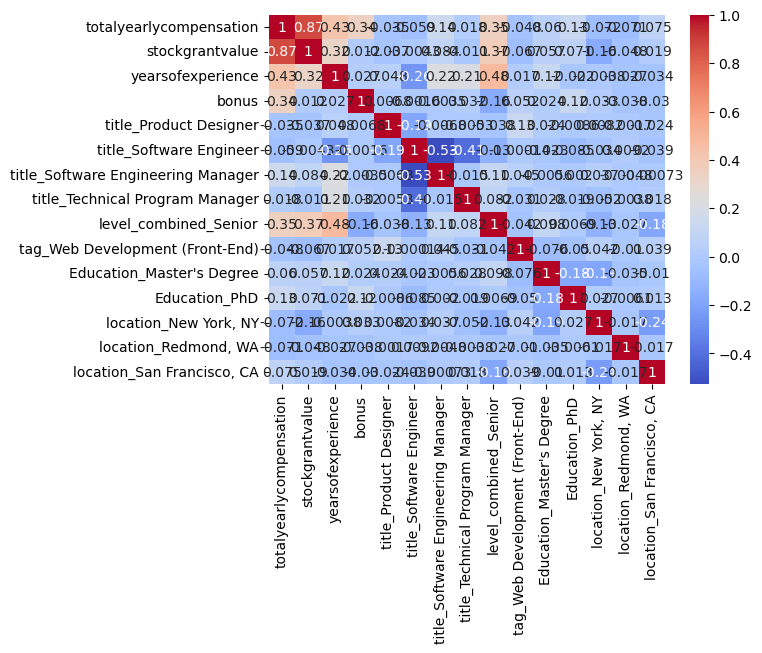

In [19]:
# Compute the correlation matrix of the cleaned DataFrame to identify relationships between features
correlation_matrix = cleaned_df.corr()

# Visualize the correlation matrix using a heatmap to facilitate interpretation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Display the correlation heatmap
plt.show()

## OLS Regression Analysis: Fitting the Model and Displaying Detailed Statistical Results


In [20]:
# Create a linear regression model to predict total yearly compensation
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Print the model coefficients and intercept
print("Model Coefficients:")
print("  Coefficients:", model.coef_)
print("  Intercept:", model.intercept_)

# Use statsmodels to obtain a more detailed regression output, including p-values and R-squared
# Add a constant term to the model
X_with_intercept = sm.add_constant(X_train)

# Create an OLS (Ordinary Least Squares) model and fit it to the training data
ols_model = sm.OLS(y_train, X_with_intercept).fit()

# Print a detailed summary of the regression
print("Regression Summary:")
print(ols_model.summary())

Model Coefficients:
  Coefficients: [ 1.20367953e+00  1.95599034e+03  1.33651172e+00 -3.38191436e+03
  5.80426963e+03  2.33420560e+04 -1.36618135e+03  8.33678145e+03
 -4.45439686e+03  9.69460847e+02  1.07229584e+04  1.20590798e+04
 -1.63463239e+04  1.58786647e+04]
  Intercept: 107608.06880590977
Regression Summary:
                               OLS Regression Results                              
Dep. Variable:     totalyearlycompensation   R-squared:                       0.914
Model:                                 OLS   Adj. R-squared:                  0.913
Method:                      Least Squares   F-statistic:                     992.1
Date:                     Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                             07:50:25   Log-Likelihood:                -14642.
No. Observations:                     1316   AIC:                         2.931e+04
Df Residuals:                         1301   BIC:                         2.939e+04
Df Model:  

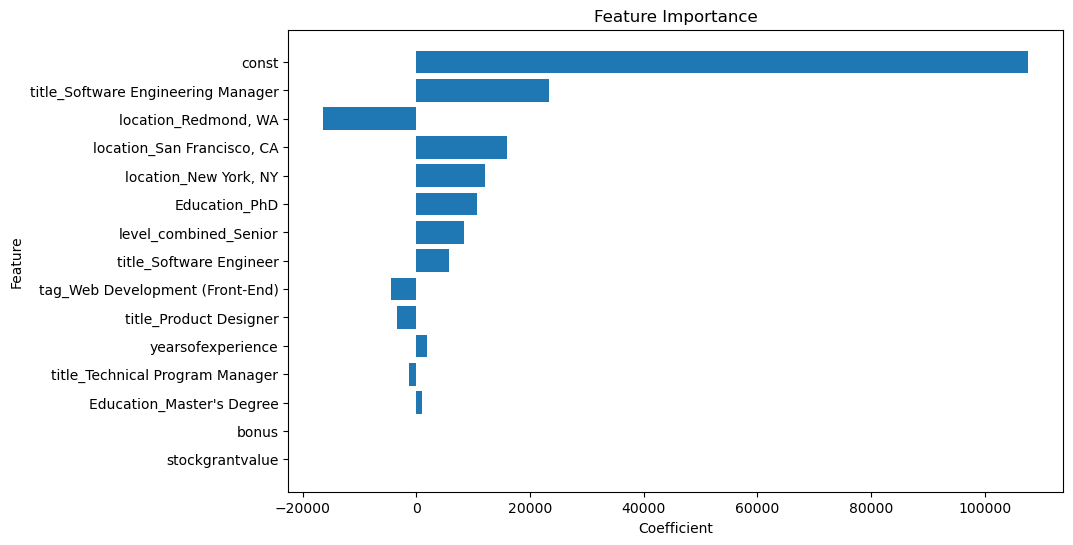

In [21]:

# Extract the coefficients from the OLS model
coefficients = ols_model.params

# Create a dataframe to hold the coefficients, with feature names as the index
df = pd.DataFrame({'Coefficient': coefficients}, index=coefficients.index)

# Sort the dataframe by absolute coefficient value
df = df.sort_values(by='Coefficient', key=abs)

# Create a horizontal bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(df.index, df['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

## Multicollinearity Check Using VIF: Calculating the Variance Inflation Factor for Each Feature


In [22]:
# Select independent variables (excluding the dependent variable)
X = cleaned_df.drop("totalyearlycompensation", axis=1)

# Add a constant for VIF calculation
X = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF results
# The output shows the Variance Inflation Factor (VIF) for each independent variable.
# A high VIF value (> 5 or 10) indicates high multicollinearity between variables,
# suggesting that the variable is highly correlated with one or more other variables.
print(vif_data)

                              Variable        VIF
0                                const  40.222825
1                      stockgrantvalue   1.267113
2                    yearsofexperience   1.522811
3                                bonus   1.079789
4               title_Product Designer   1.108273
5              title_Software Engineer   2.061207
6   title_Software Engineering Manager   1.630663
7      title_Technical Program Manager   1.408341
8                level_combined_Senior   1.596427
9      tag_Web Development (Front-End)   1.044699
10           Education_Master's Degree   1.103276
11                       Education_PhD   1.084432
12               location_New York, NY   1.177376
13                location_Redmond, WA   1.007056
14          location_San Francisco, CA   1.148330


## Lasso Regression Model and Evaluation: Training, Prediction, and Performance Metrics


In [23]:
# Step 1: Initialize Lasso regression model with a specified alpha value
alpha = 0.1  # You can change this value to any desired alpha
lasso = Lasso(alpha=alpha)

# Step 2: Train the Lasso model on the training data
lasso.fit(X_train, y_train)

# Step 3: Make predictions using the test set
y_pred = lasso.predict(X_test)

# Step 4: Evaluate the model using relevant metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Create a DataFrame with the evaluation metrics
evaluation_metrics = pd.DataFrame({
    "Metric": ["Mean Squared Error", "Root Mean Squared Error", "R2 Score"],
    "Value": [f"{mse:.4f}", f"{rmse:.4f}", f"{r2:.4f}"]
})

# The evaluation metrics table provides insight into the performance of the Lasso model.

# Create a DataFrame with the model coefficients and intercept
feature_names = X_train.columns
model_coefficients = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient ($/unit)": [f"${coef:.2f}" for coef in lasso.coef_]
})

# The model coefficients table shows the change in the dependent variable for a one-unit change in each feature, while holding all other features constant.

# Create a DataFrame with the intercept
intercept = pd.DataFrame({
    "Intercept": [f"${lasso.intercept_:.2f}"],
    "Note": ["The intercept represents the expected salary when all features are zero."]
})

# The intercept represents the expected value of the dependent variable when all features are zero.

# Generate Markdown tables for the evaluation metrics, model coefficients, and intercept
evaluation_metrics_table = [
    ["Metric", "Value"],
    ["Mean Squared Error", f"{mse:.4f}"],
    ["Root Mean Squared Error", f"{rmse:.4f}"],
    ["R2 Score", f"{r2:.4f}"]
]

model_coefficients_table = [
    ["Feature", "Coefficient ($/unit)"]
]
for feature, coef in zip(feature_names, lasso.coef_):
    model_coefficients_table.append([feature, f"${coef:.2f}"])

intercept_table = [
    ["Intercept", "Note"],
    [f"${lasso.intercept_:.2f}", "The intercept represents the expected salary when all features are zero."]
]

evaluation_metrics_markdown = tabulate(evaluation_metrics_table, headers="firstrow", tablefmt="markdown")
model_coefficients_markdown = tabulate(model_coefficients_table, headers="firstrow", tablefmt="markdown")
intercept_markdown = tabulate(intercept_table, headers="firstrow", tablefmt="markdown")

# Print the Markdown tables
print("Evaluation Metrics:")
print(evaluation_metrics_markdown)

print("\nModel Coefficients:")
print(model_coefficients_markdown)

print("\nIntercept:")
print(intercept_markdown)

Evaluation Metrics:
Metric                             Value
-----------------------  ---------------
Mean Squared Error           3.34949e+08
Root Mean Squared Error  18301.6
R2 Score                     0.9015

Model Coefficients:
Feature                             Coefficient ($/unit)
----------------------------------  ----------------------
stockgrantvalue                     $1.20
yearsofexperience                   $1955.94
bonus                               $1.34
title_Product Designer              $-3339.14
title_Software Engineer             $5802.88
title_Software Engineering Manager  $23336.17
title_Technical Program Manager     $-1358.94
level_combined_Senior               $8336.32
tag_Web Development (Front-End)     $-4453.52
Education_Master's Degree           $968.82
Education_PhD                       $10718.86
location_New York, NY               $12058.52
location_Redmond, WA                $-16280.34
location_San Francisco, CA          $15877.95

Intercept:
Interce

## Checking for Overfitting with Linear Regression: Evaluating Training and Test Performance


In [24]:
# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the training data
y_train_pred = model.predict(X_train)

# Calculate the R² score and mean squared error (MSE) for the training data
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Predict on the test data
y_test_pred = model.predict(X_test)

# Calculate the R² score and mean squared error (MSE) for the test data
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Print the R² scores and MSE values for both training and test data
# print(f"Training R²: {train_r2:.4f}, Training MSE: {train_mse:.4f}")
# print(f"Test R²: {test_r2:.4f}, Test MSE: {test_mse:.4f}")
# Create a table with the results
table = [
    ["Metric", "Training", "Test"],
    ["R² Score", f"{train_r2:.4f}", f"{test_r2:.4f}"],
    ["Mean Squared Error (MSE)", f"{train_mse:.4f}", f"{test_mse:.4f}"]
]

# Generate the Markdown table
markdown_table = tabulate(table, headers="firstrow", tablefmt="markdown")

# Print the Markdown table
print(markdown_table)



Metric                       Training         Test
------------------------  -----------  -----------
R² Score                  0.9144       0.9015
Mean Squared Error (MSE)  2.70059e+08  3.34953e+08


In [25]:


# Create a table with the results
table = [
    ["Metric", "Training", "Test"],
    ["R² Score", f"{train_r2:.4f}", f"{test_r2:.4f}"],
    ["MSE", f"{train_mse:.4f}", f"{test_mse:.4f}"]
]

# Generate the Markdown table
markdown_table = tabulate(table, headers="firstrow", tablefmt="markdown")

# Print the Markdown table
print(markdown_table)

Metric       Training         Test
--------  -----------  -----------
R² Score  0.9144       0.9015
MSE       2.70059e+08  3.34953e+08
